In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image


In [ ]:
train = r'/content/drive/MyDrive/project file/archive (6)/Training'
test = r'/content/drive/MyDrive/project file/archive (6)/Testing'


In [ ]:
fnames = os.listdir(train)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fnames


['notumor', 'glioma', 'pituitary', 'meningioma']

In [ ]:
for folder in fnames:
    folder_path = os.path.join(train, folder)
    num_images = len(os.listdir(folder_path))
    print(f"Folder '{folder}' contains {num_images} images.")

Folder 'notumor' contains 1605 images.
Folder 'glioma' contains 1341 images.
Folder 'pituitary' contains 1467 images.
Folder 'meningioma' contains 1339 images.


In [ ]:
labels = ['glioma','notumor','meningioma','pituitary']

In [ ]:
## image preprocessing
## for training
import os

X_train = []
y_train = []
image_size = 180

root =  r"/content/drive/MyDrive/project file/archive (6)/Training"

for class_folder in os.listdir(root):
    folder_path = os.path.join(root, class_folder)

    for image_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)


        if img is not None:  # Check if the image is loaded successfully
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(class_folder)
        else:
            print(f"Error: Unable to load image {img_path}")

X_train = np.array(X_train)
y_train = np.array(y_train)


In [ ]:
## for testing
import os

X_test = []
y_test = []
image_size = 180

test = r'/content/drive/MyDrive/project file/archive (6)/Testing'

for class_folder in os.listdir(test):
    folder_path = os.path.join(test, class_folder)

    for image_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image_file)
        img = cv2.imread(img_path)


        if img is not None:  # Check if the image is loaded successfully
            img = cv2.resize(img, (image_size, image_size))
            X_test.append(img)
            y_test.append(class_folder)
        else:
            print(f"Error: Unable to load image {img_path}")

X_test = np.array(X_test)
y_test = np.array(y_test)


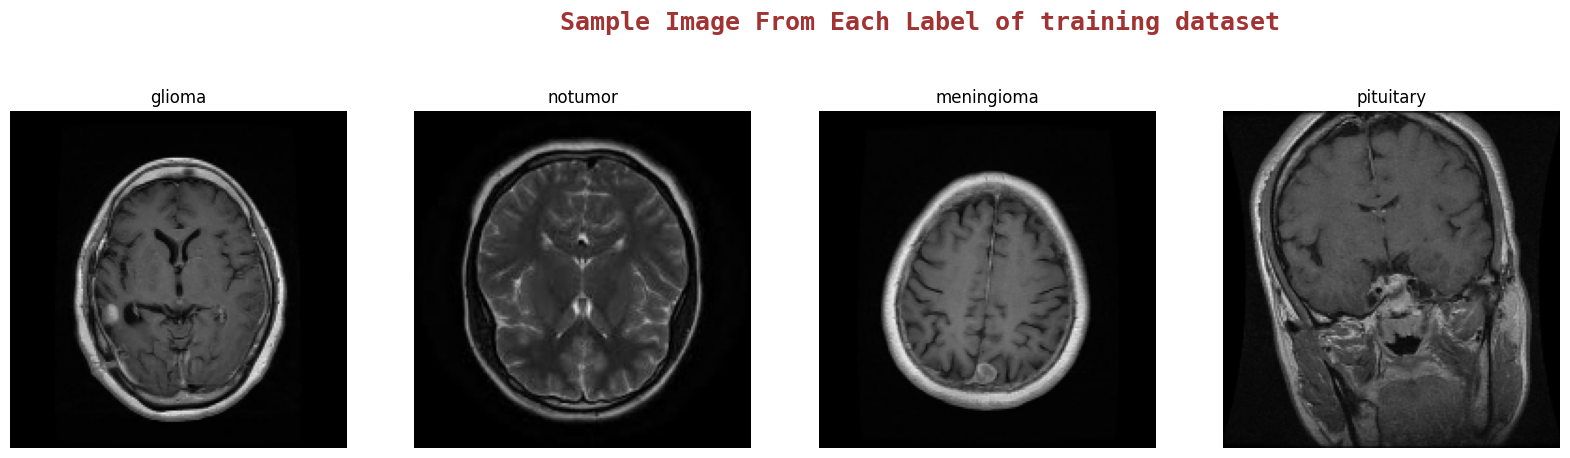

In [ ]:
## sample images from training dataset
import matplotlib.pyplot as plt

colors_dark = ['darkblue', 'darkred', 'darkgreen', 'darkorange']

k = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label of training dataset', size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=0.62, x=0.4, alpha=0.8)
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1


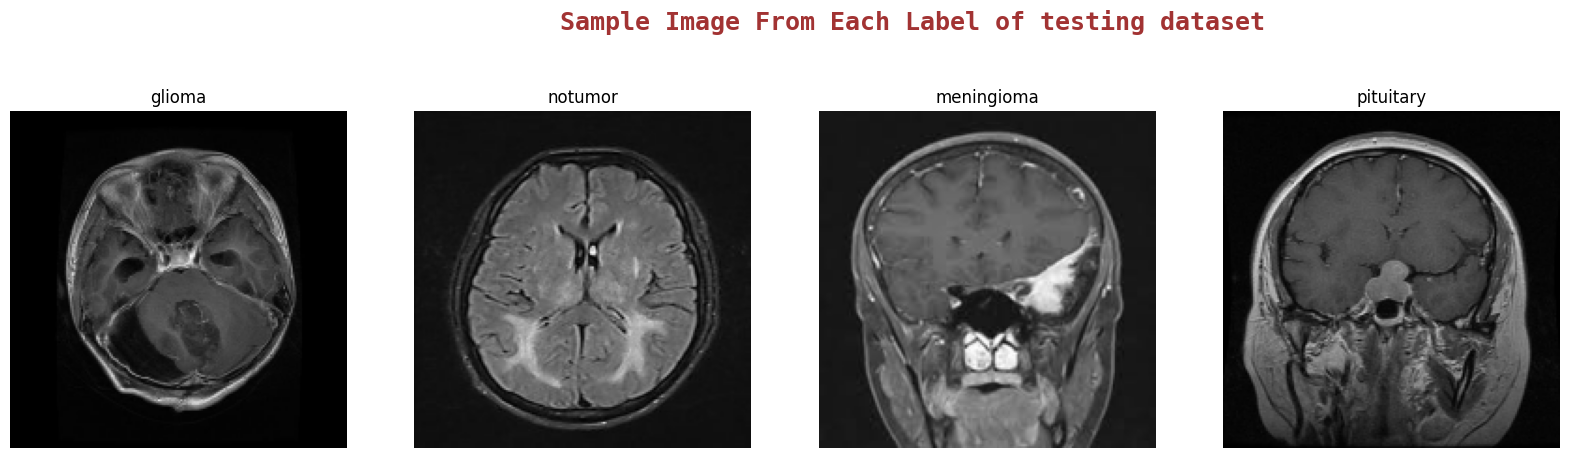

In [ ]:
## sample images from testing dataset
import matplotlib.pyplot as plt

colors_dark = ['darkblue', 'darkred', 'darkgreen', 'darkorange']

k = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label of testing dataset', size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=0.62, x=0.4, alpha=0.8)
for i in labels:
    j = 0
    while j < len(X_test):
        if y_test[j] == i:
            ax[k].imshow(X_test[j])
            ax[k].set_title(y_test[j])
            ax[k].axis('off')
            k += 1
            break
        j += 1

plt.show()


In [ ]:
## one hot encoding
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
!pip install efficientnet


In [ ]:
from efficientnet.tfkeras import EfficientNetB0

effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [ ]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 90, 90, 32)           864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 90, 90, 32)           128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 90, 90, 32)           0         ['stem_bn[0][0]']         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [ ]:

model.compile(loss='categorical_crossentropy',optimizer = 'SGD', metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
## using adam
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
162/162 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.7857
Epoch 1: val_accuracy improved from -inf to 0.42014, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


162/162 [==============================] - 70s 195ms/step - loss: 0.6291 - accuracy: 0.7857 - val_loss: 1.3589 - val_accuracy: 0.4201 - lr: 0.0100
Epoch 2/5
162/162 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9179
Epoch 2: val_accuracy improved from 0.42014 to 0.53472, saving model to effnet.h5
162/162 [==============================] - 29s 177ms/step - loss: 0.2650 - accuracy: 0.9179 - val_loss: 1.2125 - val_accuracy: 0.5347 - lr: 0.0100
Epoch 3/5
162/162 [==============================] - ETA: 0s - loss: 0.1857 - accuracy: 0.9446
Epoch 3: val_accuracy improved from 0.53472 to 0.55903, saving model to effnet.h5
162/162 [==============================] - 30s 185ms/step - loss: 0.1857 - accuracy: 0.9446 - val_loss: 1.1334 - val_accuracy: 0.5590 - lr: 0.0100
Epoch 4/5
162/162 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9509
Epoch 4: val_accuracy improved from 0.55903 to 0.63021, saving model to effnet.h5
162/162 [===================

In [ ]:
## using SGD
history = model.fit(X_train,y_train,validation_split=0.1, epochs =5, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/5
162/162 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9677
Epoch 1: val_accuracy improved from 0.63021 to 0.70486, saving model to effnet.h5
162/162 [==============================] - 30s 183ms/step - loss: 0.0976 - accuracy: 0.9677 - val_loss: 0.7444 - val_accuracy: 0.7049 - lr: 0.0100
Epoch 2/5
162/162 [==============================] - ETA: 0s - loss: 0.0825 - accuracy: 0.9722
Epoch 2: val_accuracy did not improve from 0.70486
162/162 [==============================] - 28s 175ms/step - loss: 0.0825 - accuracy: 0.9722 - val_loss: 0.8333 - val_accuracy: 0.6736 - lr: 0.0100
Epoch 3/5
162/162 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9774
Epoch 3: val_accuracy improved from 0.70486 to 0.71354, saving model to effnet.h5
162/162 [==============================] - 29s 182ms/step - loss: 0.0700 - accuracy: 0.9774 - val_loss: 0.7352 - val_accuracy: 0.7135 - lr: 0.0100
Epoch 4/5
162/162 [==============================] - ETA: 0

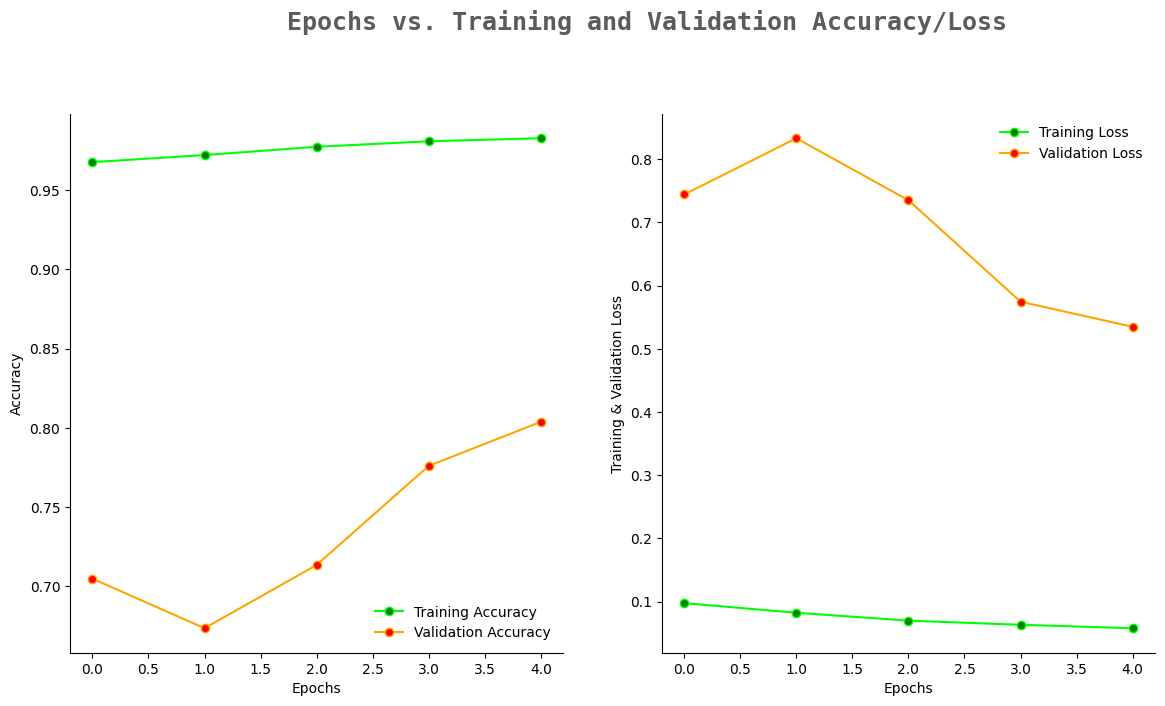

In [ ]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

epochs = [i for i in range(5)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

colors_green = ['#008000', '#00FF00', '#00CC00', '#00AA00']  # Example shades of green
colors_red = ['#FF0000', '#FFA500', '#FF6347', '#800000']  # Example shades of red
colors_dark = ['#000000', '#333333', '#666666', '#999999']  # Example shades of dark

fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Plot Training and Validation Accuracy
fig.text(s='Epochs vs. Training and Validation Accuracy/Loss', size=18, fontweight='bold',
             fontname='monospace', color=colors_dark[1], y=1, x=0.28, alpha=0.8)
sns.despine()
ax[0].plot(epochs, train_acc, marker='o', markerfacecolor=colors_green[0], color=colors_green[1],
           label='Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o', markerfacecolor=colors_red[0], color=colors_red[1],
           label='Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Plot Training and Validation Loss
sns.despine()
ax[1].plot(epochs, train_loss, marker='o', markerfacecolor=colors_green[0], color=colors_green[1],
           label='Training Loss')
ax[1].plot(epochs, val_loss, marker='o', markerfacecolor=colors_red[0], color=colors_red[1],
           label='Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

plt.show()


In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

41/41 [==============================] - 4s 69ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       300
           1       0.89      1.00      0.94       405
           2       0.96      0.78      0.86       306
           3       0.96      1.00      0.98       300

    accuracy                           0.94      1311
   macro avg       0.95      0.93      0.94      1311
weighted avg       0.94      0.94      0.94      1311



Text(0.28, 0.92, 'Heatmap of the Confusion Matrix')

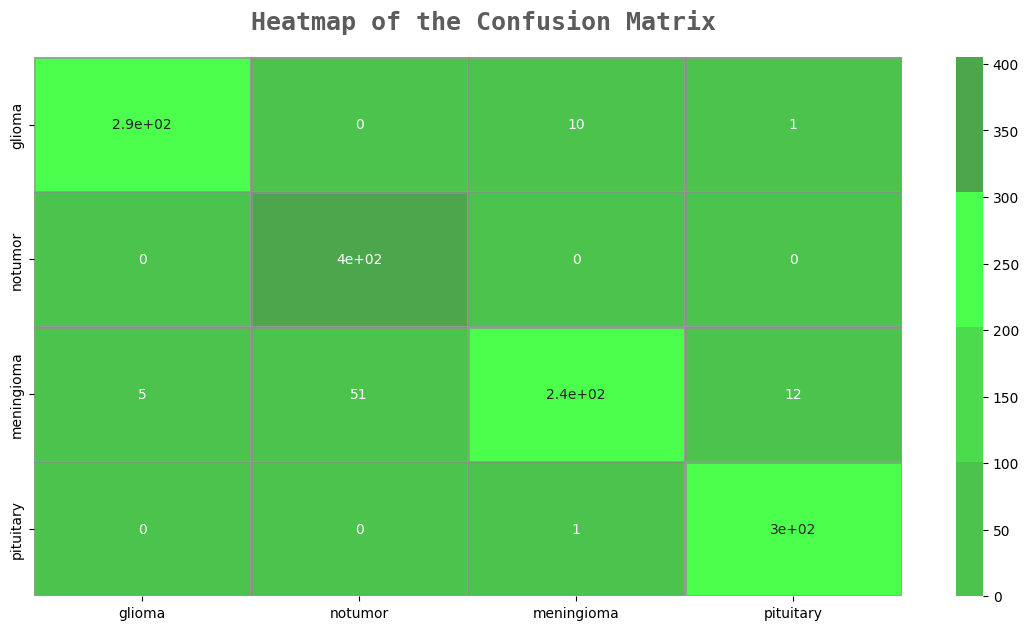

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_test_new, pred), ax=ax, xticklabels=labels, yticklabels=labels, annot=True,
            cmap=colors_green[::-1], alpha=0.7, linewidths=2, linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix', size=18, fontweight='bold',
         fontname='monospace', color=colors_dark[1], y=0.92, x=0.28, alpha=0.8)
